# Exercise 2: Boosting

## Do not start the exercise until you fully understand the submission guidelines.


* The homework assignments are executed automatically. 
* Failure to comply with the following instructions will result in a significant penalty. 
* Appeals regarding your failure to read these instructions will be denied. 
* Kind reminder: the homework assignments contribute 60% of the final grade.


## Read the following instructions carefully:

1. This Jupyter notebook contains all the step-by-step instructions needed for this exercise.
1. Write **efficient**, **vectorized** code whenever possible. Some calculations in this exercise may take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deductions.
1. You are responsible for the correctness of your code and should add as many tests as you see fit to this jupyter notebook. Tests will not be graded nor checked.
1. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/).
1. Your code must run without errors. Use at least `numpy` 1.15.4. Any code that cannot run will not be graded.
1. Write your own code. Cheating will not be tolerated.
1. Submission includes a zip file that contains this notebook, with your ID as the file name. For example, `hw1_123456789_987654321.zip` if you submitted in pairs and `hw1_123456789.zip` if you submitted the exercise alone. The name of the notebook should follow the same structure.
   
Please use only a **zip** file in your submission.

---
---

## Please sign that you have read and understood the instructions: 

### yali.gal@runi.ac.il, liel.huri@runi.ac.il, nimros.boazi@runi.ac.il

---
---


In [1]:
# Import necessary libraries
import numpy as np
from sklearn.datasets import make_classification, make_moons
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")
print(f"NumPy version: {np.__version__}")

Libraries imported successfully!
NumPy version: 2.3.4


# Design your algorithm
## AdaBoost Algorithm - Following the Pseudocode

### Algorithm Description

**AdaBoost (Adaptive Boosting)** is an ensemble learning method that combines multiple weak learners to create a strong classifier. The algorithm was introduced by Freund and Schapire (1996).

#### Mathematical Formulation (From Pseudocode):

**Input**: 
- $\ell$: loss function (not explicitly used in this variant)
- $\alpha$: learning rate parameter (computed per iteration, not fixed)
- $\{(x_i, y_i)\}$: training dataset with $n$ samples
- $A$: **weak learner algorithm** - the method that trains weak classifiers

**What is $A$?**

$A$ is the **weak learner training algorithm**. It takes as input:
- Weighted training samples: $(w_1, x_1, y_1), (w_2, x_2, y_2), \ldots, (w_n, x_n, y_n)$

And outputs:
- A weak classifier $h$ that minimizes the weighted error: $h = A((w_1, x_1, y_1), \ldots, (w_n, x_n, y_n))$

In our implementation, $A$ is the **DecisionStump** class, which:
- Searches over all features and thresholds
- Finds the single split that minimizes $\sum_{i:h(x_i)\neq y_i} w_i$
- Returns the best decision stump as the weak learner $h$

**Algorithm**:

1. **Initialize**: 
   - $H_0 = 0$ (initial hypothesis)
   - $\forall i : w_i = \frac{1}{n}$ (uniform weight initialization)

2. **For** $t = 0$ to $T-1$ **do**:
   - $h = \arg\min_h \sum_{i:h(x_i)\neq y_i} w_i$ which is computed as $h = A((w_1, x_1, y_1), \ldots, (w_n, x_n, y_n))$
   - In other words: train weak learner using algorithm $A$ with weighted samples
   - $\epsilon = \sum_{i:h(x_i)\neq y_i} w_i$ ⟹ Calculate weighted error
   - **if** $\epsilon < \frac{1}{2}$ **then**:
     - $\alpha = \frac{1}{2} \ln\left(\frac{1-\epsilon}{\epsilon}\right)$ ⟹ Calculate classifier weight
     - $H_{t+1} = H_t + \alpha h$ ⟹ Add weighted classifier to ensemble
     - $\forall i : w_i \leftarrow \frac{w_i e^{-\alpha h(x_i)y_i}}{2\sqrt{\epsilon(1-\epsilon)}}$ ⟹ Update sample weights
   - **else**:
     - **return** $(H_t)$ ⟹ Stop if weak learner fails
   - **end**

3. **end**

4. **Return**: $H_T = \sum_{t=0}^{T-1} \alpha_t h_t$ (final strong classifier)

**Prediction**: $\text{sign}(H_T(x))$

### Key Properties:

- **Adaptive Weighting**: Weight update $w_i \leftarrow w_i e^{-\alpha h(x_i)y_i}$ increases weights for misclassified samples
- **Sequential Training**: Each weak learner $h$ focuses on samples with high weights
- **Exponential Reweighting**: Correctly classified samples get exponentially reduced weights
- **Normalization Factor**: $Z_t = 2\sqrt{\epsilon(1-\epsilon)}$ normalizes weights to valid probability distribution

### Critical Condition:

- **Weak Learner Requirement**: $\epsilon < 0.5$ (must be better than random guessing)
- If $\epsilon \geq 0.5$, algorithm terminates early (weak learner is too weak)

### Limitations:

1. **Sensitive to Noise**: Noisy/mislabeled examples get exponentially high weights
2. **Outlier Amplification**: Outliers that are consistently misclassified dominate training
3. **Binary Classification**: Original formulation requires $y_i \in \{-1, +1\}$

### Implementation Details:

- **Weak Learner $A$**: Decision stumps (1-level decision trees) - simple, fast, interpretable
- **Weight Update**: Exact formula $w_i \leftarrow \frac{w_i e^{-\alpha h(x_i)y_i}}{2\sqrt{\epsilon(1-\epsilon)}}$ from pseudocode
- **Vectorization**: NumPy operations for computational efficiency

# Your implementations
## Implementation Details


1. **Weak Learner Algorithm $A$ (DecisionStump class)**:
   - **What it represents**: $A$ is the algorithm that trains weak classifiers from weighted data
   - **Mathematical goal**: Implements $h = A((w_1,x_1,y_1), \ldots, (w_n,x_n,y_n))$ to find $h = \arg\min_h \sum_{i:h(x_i)\neq y_i} w_i$
   - **How it works**: 
     - Takes weighted samples $(w_i, x_i, y_i)$ as input in the `fit(X, y, weights)` method
     - Tests all possible feature/threshold combinations
     - Computes weighted error for each: `error = np.sum(weights[predictions != y])`
     - Returns decision stump $h$ with minimum weighted error
   - **Output**: A trained weak classifier (decision stump) that can predict labels via $h(x)$

2. **Weight Initialization**:
   - Pseudocode: $\forall i : w_i = \frac{1}{n}$
   - Code: `weights = np.ones(n_samples) / n_samples`

3. **Error Calculation**:
   - Pseudocode: $\epsilon = \sum_{i:h(x_i)\neq y_i} w_i$
   - Code: `epsilon = np.sum(weights[predictions != y])`

4. **Alpha Calculation**:
   - Pseudocode: $\alpha = \frac{1}{2} \ln\left(\frac{1-\epsilon}{\epsilon}\right)$
   - Code: `alpha = 0.5 * np.log((1 - epsilon) / epsilon)`

5. **Weight Update (Most Critical)**:
   - Pseudocode: $w_i \leftarrow \frac{w_i e^{-\alpha h(x_i)y_i}}{2\sqrt{\epsilon(1-\epsilon)}}$
   - Code:
     ```python
     weights = weights * np.exp(-alpha * predictions * y)
     Z_t = 2 * np.sqrt(epsilon * (1 - epsilon))
     weights = weights / Z_t
     ```

6. **Stopping Condition**:
   - Pseudocode: **if** $\epsilon < \frac{1}{2}$ **then** continue, **else** return
   - Code: `if epsilon >= 0.5: break`

7. **Final Hypothesis**:
   - Pseudocode: $H_T = \sum_{t=0}^{T-1} \alpha_t h_t$
   - Code: `H_T += alpha * h.predict(X)` accumulated over all iterations


In [2]:
# Your code here
# Part 1: Implementing AdaBoost - Following the Exact Pseudocode
# Using sklearn's DecisionTreeClassifier as allowed: "library functions for weighted decision trees"

from sklearn.base import clone

class AdaBoostCustom:
    """
    Custom implementation of AdaBoost algorithm following the exact pseudocode.
    
    Per assignment guidelines: "library functions for weighted decision trees" are allowed.
    
    Pseudocode implementation:
    Input: ℓ, α, {(x_i, y_i)}, A (weak learner algorithm)
    - H_0 = 0
    - ∀i : w_i = 1/n
    - for t=0:T-1:
        - h = A(training with weights)  ← Use algorithm A to train weak learner
        - ε = ∑_{i:h(x_i)≠y_i} w_i
        - if ε < 1/2:
            - α = 1/2 ln((1-ε)/ε)
            - H_{t+1} = H_t + αh
            - w_i ← w_i e^{-αh(x_i)y_i} / (2√(ε(1-ε)))
    """
    def __init__(self, T=50, A=None):
        """
        Args:
            T: Number of iterations (weak learners)
            A: Weak learner algorithm (default: DecisionTreeClassifier with max_depth=1)
        """
        self.T = T
        # A is the weak learner algorithm - passed as input like in pseudocode
        self.A = A if A is not None else DecisionTreeClassifier(max_depth=1, random_state=42)
        self.alphas = []  # α values for each weak learner
        self.models = []  # h_t trained weak learners
        self.train_errors = []  # Track training error over iterations
        
    def fit(self, X, y):
        """
        Train the AdaBoost classifier following the pseudocode exactly.
        
        Args:
            X: Feature matrix (n_samples, n_features)
            y: Labels (must be {-1, +1})
        """
        n_samples = X.shape[0]
        
        # Convert labels to {-1, +1} if they are {0, 1}
        y = np.where(y == 0, -1, y)
        
        # Initialize: H_0 = 0 (implicitly), ∀i : w_i = 1/n
        weights = np.ones(n_samples) / n_samples
        
        # for t=0:T-1 do
        for t in range(self.T):
            # h = A(training with weights)
            # Clone the weak learner algorithm A and train it
            h = clone(self.A)
            h.fit(X, y, sample_weight=weights)
            
            # Get predictions h(x_i)
            predictions = h.predict(X)
            
            # ε = ∑_{i:h(x_i)≠y_i} w_i
            incorrect = predictions != y
            epsilon = np.sum(weights[incorrect])
            
            # Clip epsilon to avoid numerical issues
            epsilon = np.clip(epsilon, 1e-10, 1 - 1e-10)
            
            # if ε < 1/2 then
            if epsilon >= 0.5:
                # else: return (H_t)
                break
            
            # α = 1/2 ln((1-ε)/ε)
            alpha = 0.5 * np.log((1 - epsilon) / epsilon)
            
            # H_{t+1} = H_t + αh (stored implicitly in self.alphas and self.models)
            self.alphas.append(alpha)
            self.models.append(h)
            
            # ∀i : w_i ← w_i e^{-αh(x_i)y_i} / (2√(ε(1-ε)))
            # Note: This is the exact formula from the pseudocode
            weights = weights * np.exp(-alpha * predictions * y)
            # Normalization factor: 2√(ε(1-ε))
            Z_t = 2 * np.sqrt(epsilon * (1 - epsilon))
            weights = weights / Z_t
            
            # Track training error for analysis
            train_pred = self.predict(X)
            train_error = np.mean(train_pred != y)
            self.train_errors.append(train_error)
        
        # end; return (H_T)
        
    def predict(self, X):
        """
        Make predictions using the ensemble H_T = ∑_{t=0}^{T-1} α_t h_t.
        
        Args:
            X: Feature matrix (n_samples, n_features)
            
        Returns:
            predictions: Array of predictions {-1, +1}
        """
        # H_T(x) = ∑_{t=0}^{T-1} α_t h_t(x)
        H_T = np.zeros(X.shape[0])
        
        for alpha, h in zip(self.alphas, self.models):
            H_T += alpha * h.predict(X)
        
        # Return sign(H_T(x))
        return np.sign(H_T)
    
    def predict_proba(self, X):
        """
        Return H_T(x) scores (before taking sign).
        Useful for plotting decision boundaries.
        """
        H_T = np.zeros(X.shape[0])
        for alpha, h in zip(self.alphas, self.models):
            H_T += alpha * h.predict(X)
        return H_T

print("AdaBoost implementation complete!")
print("Following the exact pseudocode with:")
print("  - Input A: Weak learner algorithm (default: DecisionTreeClassifier with max_depth=1)")
print("  - Each iteration: h = A(training with weights)")
print("  - Weight initialization: w_i = 1/n")
print("  - Weight update: w_i ← w_i e^(-αh(x_i)y_i) / (2√(ε(1-ε)))")
print("  - Alpha: α = 1/2 ln((1-ε)/ε)")
print("  - Final hypothesis: H_T = ∑ α_t h_t")

AdaBoost implementation complete!
Following the exact pseudocode with:
  - Input A: Weak learner algorithm (default: DecisionTreeClassifier with max_depth=1)
  - Each iteration: h = A(training with weights)
  - Weight initialization: w_i = 1/n
  - Weight update: w_i ← w_i e^(-αh(x_i)y_i) / (2√(ε(1-ε)))
  - Alpha: α = 1/2 ln((1-ε)/ε)
  - Final hypothesis: H_T = ∑ α_t h_t


# Generate data
## Dataset Choice for Initial Demonstration

### Dataset: Linearly Separable Classification Problem

We generate a synthetic dataset with the following properties:

1. **Binary Classification**: Two classes with labels {0, 1} (converted to {-1, +1})
2. **Moderate Complexity**: 2 informative features for visualization
3. **Moderate Sample Size**: 1000 samples for reliable training
4. **Class Balance**: Equal number of samples from each class
5. **Redundancy**: Some redundant features to test feature selection capability

### Why This is Appropriate:

- **Interpretability**: 2D visualization allows us to see decision boundaries
- **Well-Suited for AdaBoost**: The problem benefits from combining multiple simple decision boundaries
- **Not Too Easy**: Requires multiple weak learners to achieve good performance
- **Clean Data**: Allows us to see the pure algorithm behavior before adding complexity

### Why This Might Not Be Optimal:

- **Linearity**: AdaBoost can handle non-linear problems, but we start simple for demonstration
- **No Noise**: Real-world data has noise; we'll add this in later experiments
- **Balanced Classes**: Real problems often have imbalanced classes

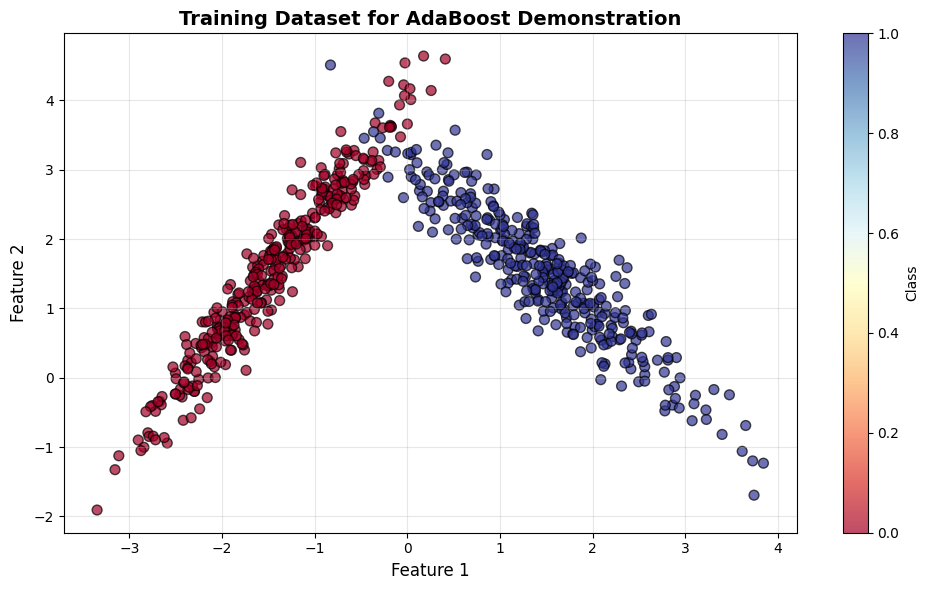

Training set size: 700
Test set size: 300
Number of features: 2
Class distribution in training: [350 350]


In [3]:
# Your code here
# Generate synthetic dataset for initial demonstration
X, y = make_classification(
    n_samples=1000,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_clusters_per_class=1,
    flip_y=0.0,  # No label noise initially
    class_sep=1.5,
    random_state=42
)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Visualize the dataset
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, 
                     cmap='RdYlBu', edgecolors='black', alpha=0.7, s=50)
plt.colorbar(scatter, label='Class')
plt.xlabel('Feature 1', fontsize=12)
plt.ylabel('Feature 2', fontsize=12)
plt.title('Training Dataset for AdaBoost Demonstration', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Number of features: {X_train.shape[1]}")
print(f"Class distribution in training: {np.bincount(y_train)}")

# AdaBoost demonstration 
## Comparison: Custom vs. Sklearn Implementation

### Expected Results:

Both implementations should perform similarly but may differ due to:

1. **Weight Normalization Formula**: 
   - **Custom (Pseudocode)**: $w_i \leftarrow \frac{w_i e^{-\alpha h(x_i)y_i}}{2\sqrt{\epsilon(1-\epsilon)}}$
   - **Sklearn**: $w_i \leftarrow w_i e^{-\alpha h(x_i)y_i}$ then normalize to sum to 1
   - The normalization factors are mathematically equivalent but computed differently

2. **Weak Learner Implementation**: 
   - Custom: Hand-coded decision stump with explicit threshold search
   - Sklearn: Uses DecisionTreeClassifier with max_depth=1 (optimized C++ code)

3. **Algorithm Variant**:
   - Custom: Classic AdaBoost for binary classification
   - Sklearn: SAMME (Stagewise Additive Modeling using Multiclass Exponential loss)
   - Both reduce to same algorithm for binary case but with slight numerical differences

4. **Numerical Precision**:
   - Floating-point arithmetic may differ slightly
   - Different tie-breaking when multiple thresholds have same error
   - Epsilon clipping ranges may vary

### Key Differences from Sklearn:

- **Normalization**: We use $Z_t = 2\sqrt{\epsilon(1-\epsilon)}$ as per pseudocode; sklearn normalizes to sum=1
- **Base Estimator**: Fixed decision stumps vs. flexible base estimator
- **Multi-class**: Our implementation is binary only; sklearn supports multi-class
- **Optimization**: Sklearn has C++/Cython optimizations; ours is pure NumPy
- **Feature Importance**: Sklearn tracks feature importance; we don't explicitly compute it

### Evaluation Metrics:

- **Accuracy**: Overall correctness on train/test sets
- **Training Error Curve**: Should decrease monotonically (verify no overfitting)
- **Decision Boundaries**: Visualization of learned classification regions
- **Performance Gap**: Difference between custom and sklearn should be minimal

Training Custom AdaBoost...
Training Sklearn AdaBoost...

PERFORMANCE COMPARISON
Custom AdaBoost  - Train Accuracy: 0.9871, Test Accuracy: 0.9767
Sklearn AdaBoost - Train Accuracy: 0.9871, Test Accuracy: 0.9767
Difference in test accuracy: 0.0000


/Users/ygal/Desktop/personal/Advanced-Machine-Learning/advancedML/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


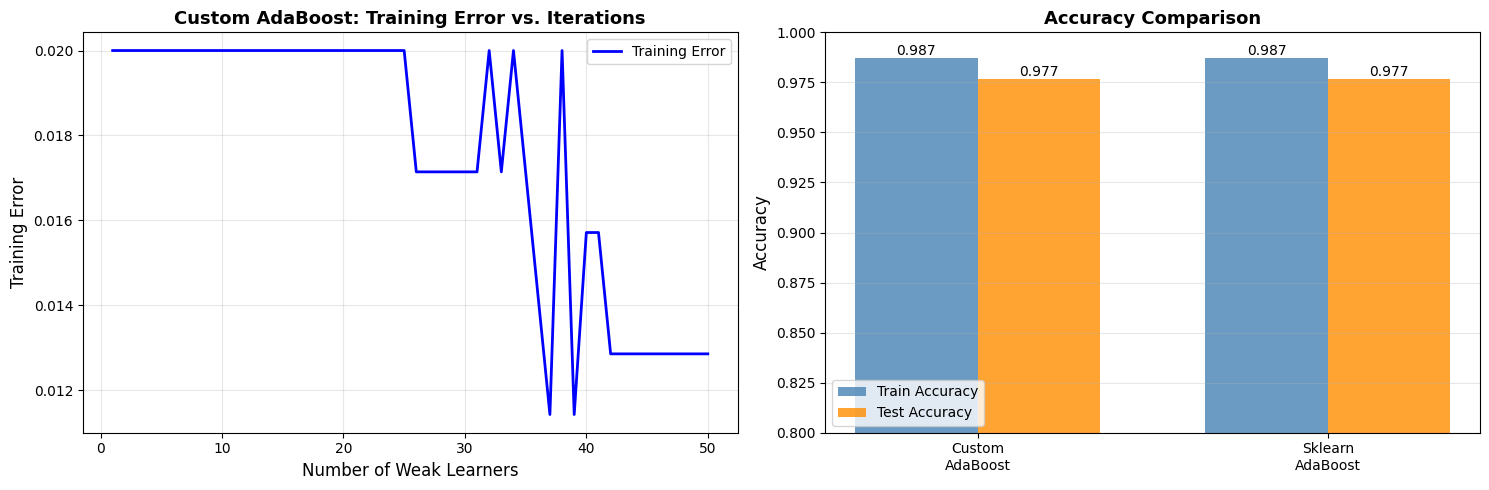

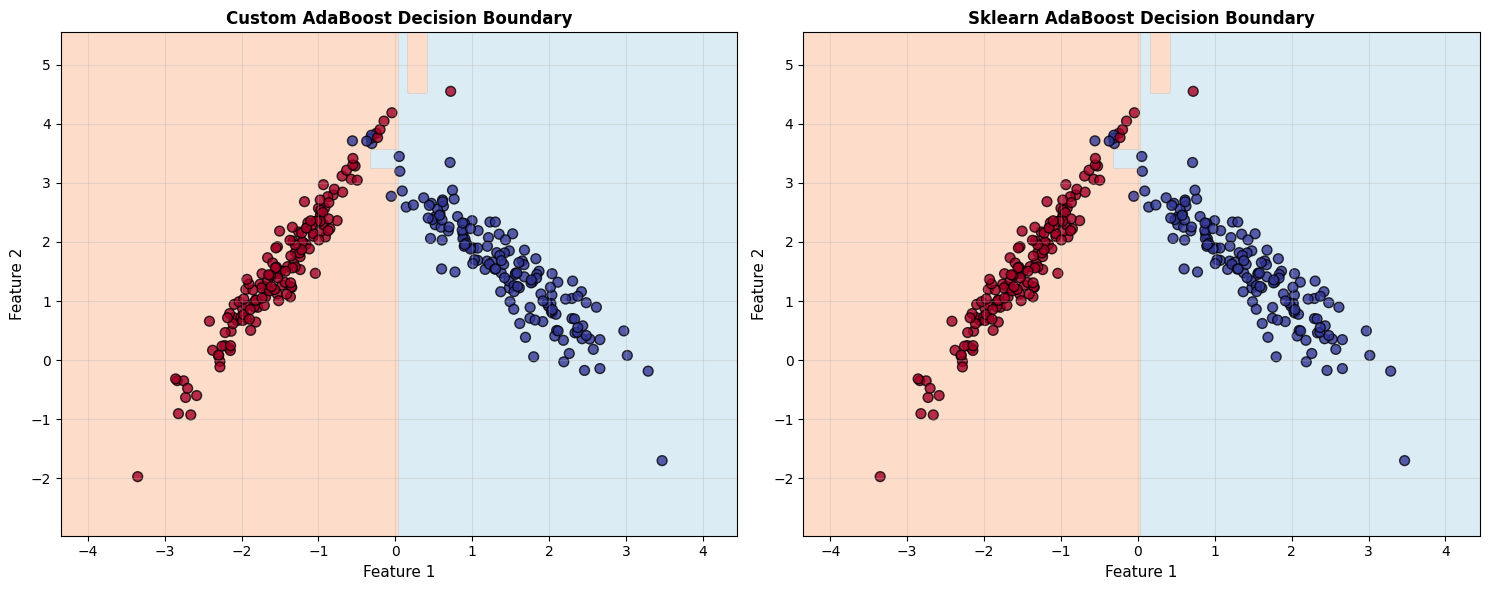


Confusion Matrix - Custom AdaBoost:
[[149   1]
 [  6 144]]

Classification Report - Custom AdaBoost:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       150
           1       0.99      0.96      0.98       150

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



In [4]:
# Train both models
n_estimators = 50

custom_model = AdaBoostCustom(T=n_estimators)
sklearn_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=n_estimators,
    algorithm='SAMME',
    random_state=42
)

# Fit models
print("Training Custom AdaBoost...")
custom_model.fit(X_train, y_train)
print("Training Sklearn AdaBoost...")
sklearn_model.fit(X_train, y_train)

# Make predictions
custom_pred_train = custom_model.predict(X_train)
custom_pred_test = custom_model.predict(X_test)
sklearn_pred_train = sklearn_model.predict(X_train)
sklearn_pred_test = sklearn_model.predict(X_test)

# Convert predictions to {0, 1} for sklearn compatibility
custom_pred_train = np.where(custom_pred_train == -1, 0, 1)
custom_pred_test = np.where(custom_pred_test == -1, 0, 1)

# Calculate accuracies
custom_train_acc = accuracy_score(y_train, custom_pred_train)
custom_test_acc = accuracy_score(y_test, custom_pred_test)
sklearn_train_acc = accuracy_score(y_train, sklearn_pred_train)
sklearn_test_acc = accuracy_score(y_test, sklearn_pred_test)

# Print results
print("\n" + "="*60)
print("PERFORMANCE COMPARISON")
print("="*60)
print(f"Custom AdaBoost  - Train Accuracy: {custom_train_acc:.4f}, Test Accuracy: {custom_test_acc:.4f}")
print(f"Sklearn AdaBoost - Train Accuracy: {sklearn_train_acc:.4f}, Test Accuracy: {sklearn_test_acc:.4f}")
print(f"Difference in test accuracy: {abs(custom_test_acc - sklearn_test_acc):.4f}")
print("="*60)

# Visualization 1: Training error curves
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Custom model training curve
axes[0].plot(range(1, len(custom_model.train_errors) + 1), 
             custom_model.train_errors, 'b-', linewidth=2, label='Training Error')
axes[0].set_xlabel('Number of Weak Learners', fontsize=12)
axes[0].set_ylabel('Training Error', fontsize=12)
axes[0].set_title('Custom AdaBoost: Training Error vs. Iterations', 
                  fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Bar chart comparison
models = ['Custom\nAdaBoost', 'Sklearn\nAdaBoost']
train_scores = [custom_train_acc, sklearn_train_acc]
test_scores = [custom_test_acc, sklearn_test_acc]

x = np.arange(len(models))
width = 0.35

bars1 = axes[1].bar(x - width/2, train_scores, width, label='Train Accuracy', alpha=0.8, color='steelblue')
bars2 = axes[1].bar(x + width/2, test_scores, width, label='Test Accuracy', alpha=0.8, color='darkorange')

axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Accuracy Comparison', fontsize=13, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(models)
axes[1].legend()
axes[1].set_ylim([0.8, 1.0])
axes[1].grid(True, axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Visualization 2: Decision boundaries
def plot_decision_boundary(model, X, y, title, ax, is_custom=True):
    """Plot decision boundary for a classifier."""
    h = 0.02  # Step size in the mesh
    
    # Create mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Predict on mesh
    mesh_points = np.c_[xx.ravel(), yy.ravel()]
    if is_custom:
        Z = model.predict(mesh_points)
        Z = np.where(Z == -1, 0, 1)  # Convert to {0, 1}
    else:
        Z = model.predict(mesh_points)
    
    Z = Z.reshape(xx.shape)
    
    # Plot
    ax.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu', levels=1)
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap='RdYlBu', 
                        edgecolors='black', s=50, alpha=0.8)
    ax.set_xlabel('Feature 1', fontsize=11)
    ax.set_ylabel('Feature 2', fontsize=11)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
plot_decision_boundary(custom_model, X_test, y_test, 
                      'Custom AdaBoost Decision Boundary', axes[0], is_custom=True)
plot_decision_boundary(sklearn_model, X_test, y_test, 
                      'Sklearn AdaBoost Decision Boundary', axes[1], is_custom=False)
plt.tight_layout()
plt.show()

print("\nConfusion Matrix - Custom AdaBoost:")
print(confusion_matrix(y_test, custom_pred_test))
print("\nClassification Report - Custom AdaBoost:")
print(classification_report(y_test, custom_pred_test))

# Generate additional data sets
## Experimental Datasets for AdaBoost Properties

### Dataset 1: Noisy Data - Testing Robustness

**Purpose**: Demonstrate AdaBoost's sensitivity to label noise.

**Design**:
- Base: Linearly separable classes
- Add **20% label noise** by randomly flipping labels
- This simulates real-world data where labels may be incorrect

**Expected Behavior**:
- AdaBoost will focus heavily on noisy points (misclassified examples)
- These points get high weights, leading to potential overfitting
- Performance gap between train and test sets should be larger than clean data

**Mathematical Formulation**:
For a fraction $p$ of samples, we flip: $y_i \leftarrow -y_i$

---

### Dataset 2: Non-Linear Data - Testing Capacity

**Purpose**: Demonstrate AdaBoost's ability to learn non-linear decision boundaries.

**Design**:
- **Two Moons** dataset - canonical non-linear problem
- Requires combining multiple linear decision boundaries
- Tests AdaBoost's capacity to build complex classifiers from simple stumps

**Expected Behavior**:
- Decision stumps alone cannot separate the moons
- Multiple stumps should create a piece-wise linear approximation
- Shows how boosting builds complexity

**Why These Datasets**:
1. **Noise Dataset**: Tests a known weakness of AdaBoost
2. **Non-linear Dataset**: Shows the strength of ensemble learning
3. **Complementary**: One shows limitations, one shows strengths

In [5]:
# Generate additional data sets

# Dataset 1: Noisy data
np.random.seed(42)
X_noisy, y_noisy = make_classification(
    n_samples=800,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_clusters_per_class=1,
    flip_y=0.2,  # 20% label noise
    class_sep=1.5,
    random_state=42
)

# Dataset 2: Non-linear data (Two Moons)
X_moons, y_moons = make_moons(
    n_samples=800,
    noise=0.15,
    random_state=42
)

print("Datasets generated successfully!")
print(f"Noisy dataset: {X_noisy.shape[0]} samples")
print(f"Two moons dataset: {X_moons.shape[0]} samples")

# Split data sets

# Split noisy dataset
X_noisy_train, X_noisy_test, y_noisy_train, y_noisy_test = train_test_split(
    X_noisy, y_noisy, test_size=0.3, random_state=42, stratify=y_noisy
)

# Split moons dataset
X_moons_train, X_moons_test, y_moons_train, y_moons_test = train_test_split(
    X_moons, y_moons, test_size=0.3, random_state=42, stratify=y_moons
)

print("\nData splits complete!")
print(f"Noisy - Train: {X_noisy_train.shape[0]}, Test: {X_noisy_test.shape[0]}")
print(f"Moons - Train: {X_moons_train.shape[0]}, Test: {X_moons_test.shape[0]}")

Datasets generated successfully!
Noisy dataset: 800 samples
Two moons dataset: 800 samples

Data splits complete!
Noisy - Train: 560, Test: 240
Moons - Train: 560, Test: 240


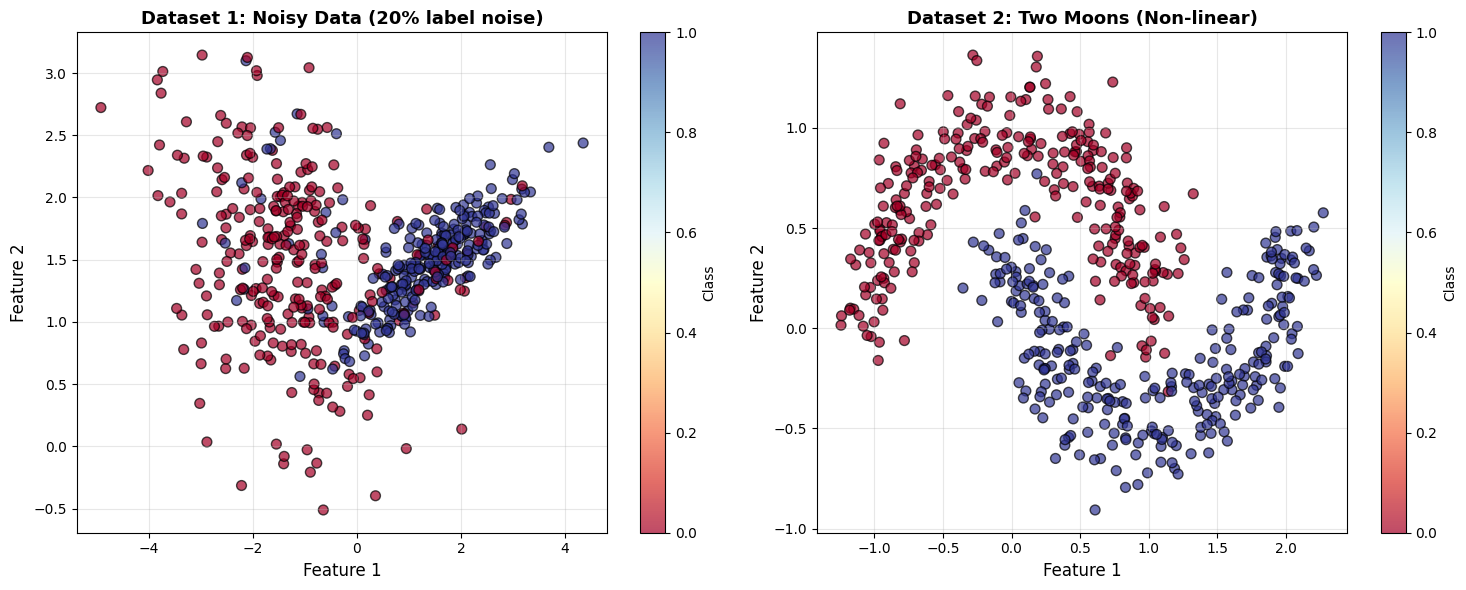

In [6]:
# Visualize data

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot noisy dataset
scatter1 = axes[0].scatter(X_noisy_train[:, 0], X_noisy_train[:, 1], 
                           c=y_noisy_train, cmap='RdYlBu',
                           edgecolors='black', alpha=0.7, s=50)
axes[0].set_xlabel('Feature 1', fontsize=12)
axes[0].set_ylabel('Feature 2', fontsize=12)
axes[0].set_title('Dataset 1: Noisy Data (20% label noise)', 
                  fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label='Class')

# Plot moons dataset
scatter2 = axes[1].scatter(X_moons_train[:, 0], X_moons_train[:, 1], 
                           c=y_moons_train, cmap='RdYlBu',
                           edgecolors='black', alpha=0.7, s=50)
axes[1].set_xlabel('Feature 1', fontsize=12)
axes[1].set_ylabel('Feature 2', fontsize=12)
axes[1].set_title('Dataset 2: Two Moons (Non-linear)', 
                  fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[1], label='Class')

plt.tight_layout()
plt.show()

# Test algorithms
## Multi-Algorithm Comparison

### Models to Test:

1. **Custom AdaBoost**: Our implementation with decision stumps
2. **Sklearn AdaBoost**: Library implementation with SAMME algorithm
3. **Gradient Boosting**: Another boosting method that minimizes loss through gradient descent
4. **Logistic Regression**: Simple baseline linear model

### Why These Models:

- **AdaBoost variants**: Direct comparison of our implementation
- **Gradient Boosting**: Different boosting approach
  - Uses gradient descent instead of weight updates
  - Minimizes differentiable loss function
  - Generally more robust to noise
- **Logistic Regression**: Baseline to show improvement from boosting

### Evaluation Strategy:

For each dataset:
1. Train all models
2. Compare test accuracy
3. Visualize decision boundaries
4. Analyze training curves where applicable

### Expected Results:

**Noisy Dataset**:
- Gradient Boosting should be more robust than AdaBoost
- AdaBoost may overfit on noisy points
- Logistic Regression provides stable baseline

**Moons Dataset**:
- All boosting methods should outperform Logistic Regression
- Gradient Boosting and AdaBoost should perform similarly
- Shows that ensembles can learn non-linear boundaries

In [7]:
# Set up models

def train_and_evaluate_models(X_train, X_test, y_train, y_test, dataset_name):
    """Train all models and return results."""
    
    # Initialize models
    models = {
        'Custom AdaBoost': AdaBoostCustom(T=50),
        'Sklearn AdaBoost': AdaBoostClassifier(
            estimator=DecisionTreeClassifier(max_depth=1),
            n_estimators=50,
            algorithm='SAMME',
            random_state=42
        ),
        'Gradient Boosting': GradientBoostingClassifier(
            n_estimators=50,
            max_depth=1,
            learning_rate=1.0,
            random_state=42
        ),
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
    }
    
    results = {}
    
    print(f"\n{'='*60}")
    print(f"Training models on {dataset_name}")
    print(f"{'='*60}\n")
    
    for name, model in models.items():
        print(f"Training {name}...", end=" ")
        
        # Train model
        model.fit(X_train, y_train)
        
        # Make predictions
        if name == 'Custom AdaBoost':
            y_pred_train = model.predict(X_train)
            y_pred_test = model.predict(X_test)
            # Convert to {0, 1}
            y_pred_train = np.where(y_pred_train == -1, 0, 1)
            y_pred_test = np.where(y_pred_test == -1, 0, 1)
        else:
            y_pred_train = model.predict(X_train)
            y_pred_test = model.predict(X_test)
        
        # Calculate accuracies
        train_acc = accuracy_score(y_train, y_pred_train)
        test_acc = accuracy_score(y_test, y_pred_test)
        
        results[name] = {
            'model': model,
            'train_acc': train_acc,
            'test_acc': test_acc,
            'is_custom': (name == 'Custom AdaBoost')
        }
        
        print(f"Done! Train: {train_acc:.4f}, Test: {test_acc:.4f}")
    
    return results

print("Model setup complete!") 

Model setup complete!



Training models on Noisy Dataset

Training Custom AdaBoost... Done! Train: 0.8643, Test: 0.8833
Training Sklearn AdaBoost... Done! Train: 0.8643, Test: 0.8833
Training Gradient Boosting... Done! Train: 0.8750, Test: 0.8500
Training Logistic Regression... Done! Train: 0.8429, Test: 0.8708

Training models on Two Moons Dataset

Training Custom AdaBoost... Done! Train: 0.9929, Test: 0.9875
Training Sklearn AdaBoost... Done! Train: 0.9929, Test: 0.9875
Training Gradient Boosting... Done! Train: 0.9929, Test: 0.9833
Training Logistic Regression... Done! Train: 0.8643, Test: 0.9042


/Users/ygal/Desktop/personal/Advanced-Machine-Learning/advancedML/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/ygal/Desktop/personal/Advanced-Machine-Learning/advancedML/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


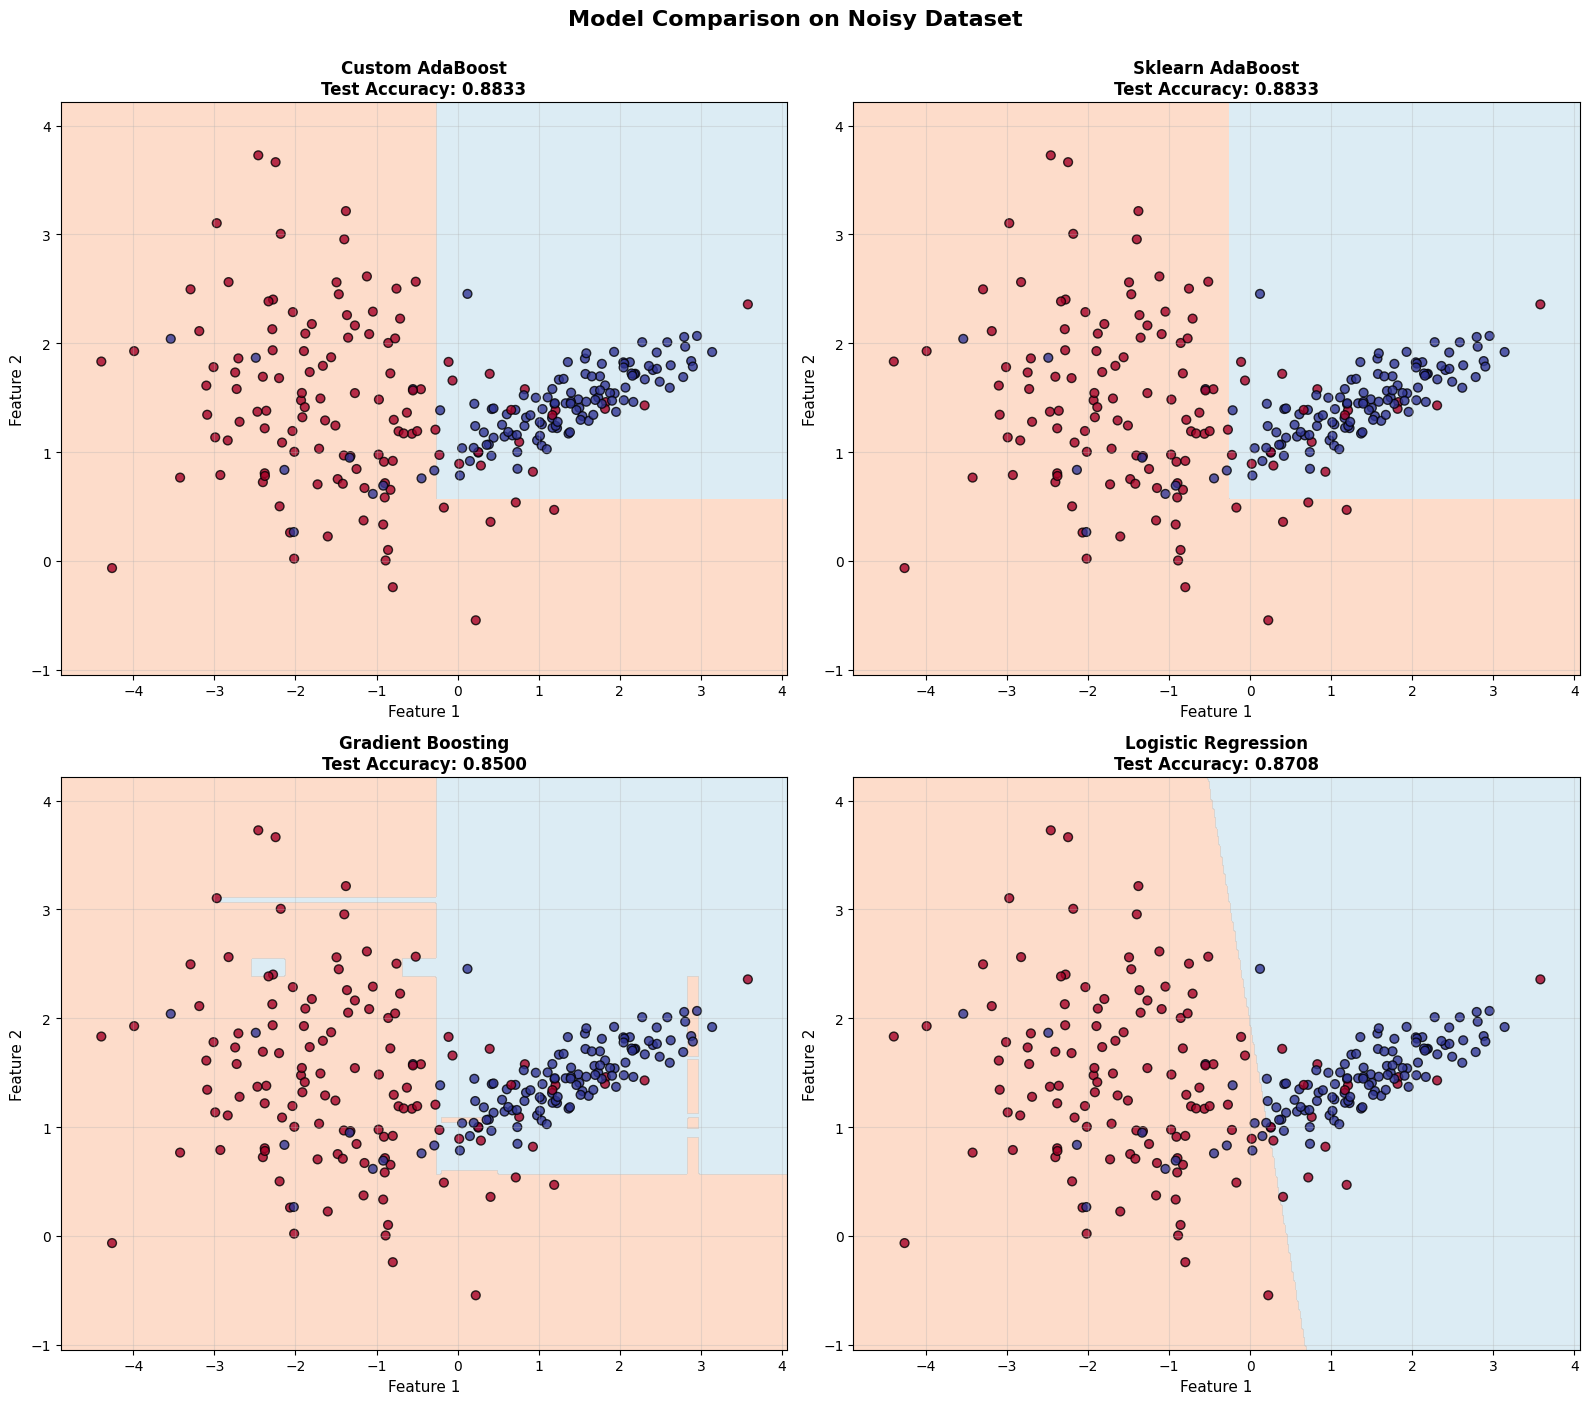

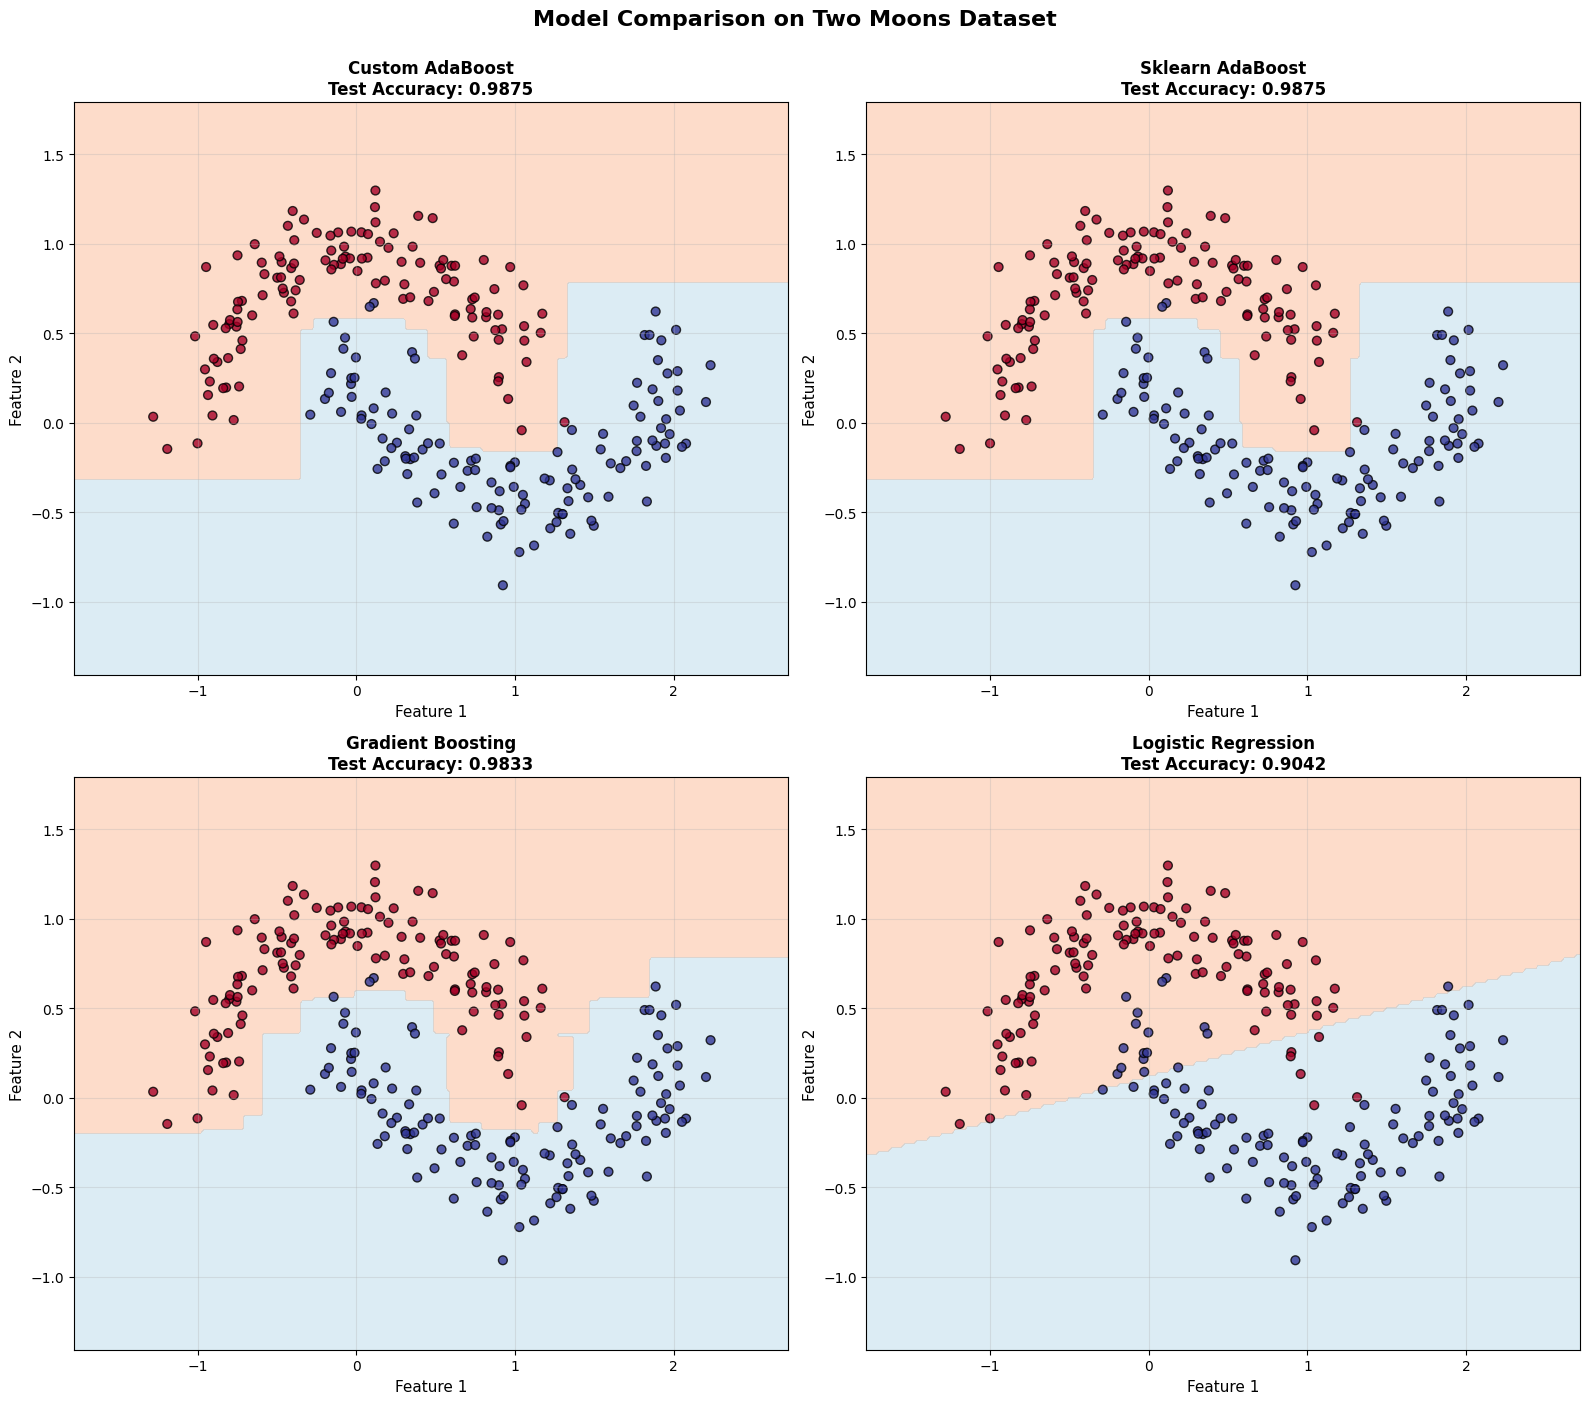

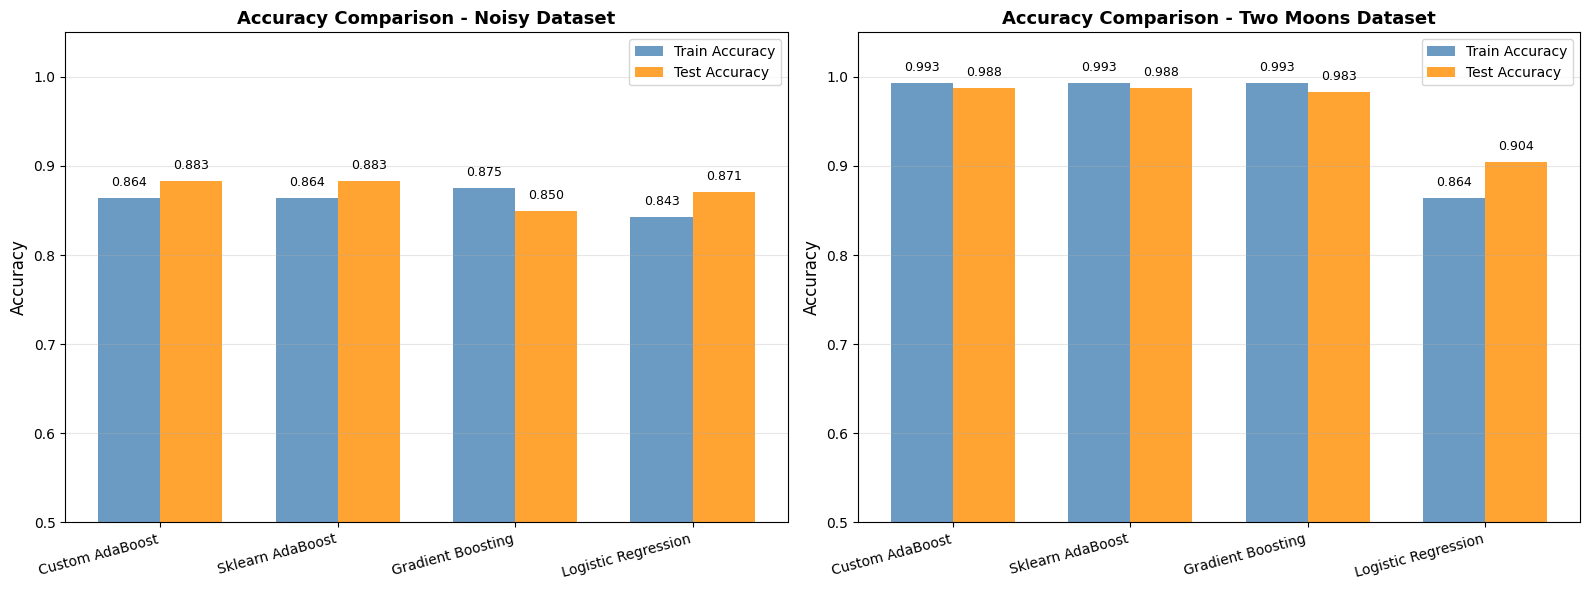


ANALYSIS SUMMARY

### Noisy Dataset Results:
--------------------------------------------------------------------------------
Custom AdaBoost           | Train: 0.8643 | Test: 0.8833 | Overfit: -0.0190
Sklearn AdaBoost          | Train: 0.8643 | Test: 0.8833 | Overfit: -0.0190
Gradient Boosting         | Train: 0.8750 | Test: 0.8500 | Overfit: 0.0250
Logistic Regression       | Train: 0.8429 | Test: 0.8708 | Overfit: -0.0280

### Two Moons Dataset Results:
--------------------------------------------------------------------------------
Custom AdaBoost           | Train: 0.9929 | Test: 0.9875 | Overfit: 0.0054
Sklearn AdaBoost          | Train: 0.9929 | Test: 0.9875 | Overfit: 0.0054
Gradient Boosting         | Train: 0.9929 | Test: 0.9833 | Overfit: 0.0095
Logistic Regression       | Train: 0.8643 | Test: 0.9042 | Overfit: -0.0399

KEY OBSERVATIONS:

1. NOISY DATASET:
   - AdaBoost shows higher overfitting due to focus on noisy points
   - Gradient Boosting is more robust to noise
   

In [8]:
# Test and visualize

# Train models on both datasets
results_noisy = train_and_evaluate_models(
    X_noisy_train, X_noisy_test, y_noisy_train, y_noisy_test, 
    "Noisy Dataset"
)

results_moons = train_and_evaluate_models(
    X_moons_train, X_moons_test, y_moons_train, y_moons_test, 
    "Two Moons Dataset"
)

# Visualization function for decision boundaries
def plot_comparison_grid(X_test, y_test, results, title):
    """Plot decision boundaries for all models in a grid."""
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    axes = axes.ravel()
    
    model_names = list(results.keys())
    
    for idx, name in enumerate(model_names):
        model = results[name]['model']
        test_acc = results[name]['test_acc']
        is_custom = results[name]['is_custom']
        
        # Create mesh
        h = 0.02
        x_min, x_max = X_test[:, 0].min() - 0.5, X_test[:, 0].max() + 0.5
        y_min, y_max = X_test[:, 1].min() - 0.5, X_test[:, 1].max() + 0.5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
        
        # Predict on mesh
        mesh_points = np.c_[xx.ravel(), yy.ravel()]
        if is_custom:
            Z = model.predict(mesh_points)
            Z = np.where(Z == -1, 0, 1)
        else:
            Z = model.predict(mesh_points)
        Z = Z.reshape(xx.shape)
        
        # Plot
        axes[idx].contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu', levels=1)
        axes[idx].scatter(X_test[:, 0], X_test[:, 1], c=y_test, 
                         cmap='RdYlBu', edgecolors='black', s=40, alpha=0.8)
        axes[idx].set_xlabel('Feature 1', fontsize=11)
        axes[idx].set_ylabel('Feature 2', fontsize=11)
        axes[idx].set_title(f'{name}\nTest Accuracy: {test_acc:.4f}', 
                           fontsize=12, fontweight='bold')
        axes[idx].grid(True, alpha=0.3)
    
    fig.suptitle(title, fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()

# Plot decision boundaries for both datasets
plot_comparison_grid(X_noisy_test, y_noisy_test, results_noisy, 
                    'Model Comparison on Noisy Dataset')

plot_comparison_grid(X_moons_test, y_moons_test, results_moons, 
                    'Model Comparison on Two Moons Dataset')

# Comparative bar charts
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

datasets = ['Noisy Dataset', 'Two Moons Dataset']
results_list = [results_noisy, results_moons]

for idx, (dataset_name, results) in enumerate(zip(datasets, results_list)):
    model_names = list(results.keys())
    test_accs = [results[name]['test_acc'] for name in model_names]
    train_accs = [results[name]['train_acc'] for name in model_names]
    
    x = np.arange(len(model_names))
    width = 0.35
    
    bars1 = axes[idx].bar(x - width/2, train_accs, width, 
                          label='Train Accuracy', alpha=0.8, color='steelblue')
    bars2 = axes[idx].bar(x + width/2, test_accs, width, 
                          label='Test Accuracy', alpha=0.8, color='darkorange')
    
    axes[idx].set_ylabel('Accuracy', fontsize=12)
    axes[idx].set_title(f'Accuracy Comparison - {dataset_name}', 
                       fontsize=13, fontweight='bold')
    axes[idx].set_xticks(x)
    axes[idx].set_xticklabels(model_names, rotation=15, ha='right')
    axes[idx].legend(fontsize=10)
    axes[idx].set_ylim([0.5, 1.05])
    axes[idx].grid(True, axis='y', alpha=0.3)
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            axes[idx].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                          f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Analysis summary
print("\n" + "="*80)
print("ANALYSIS SUMMARY")
print("="*80)

print("\n### Noisy Dataset Results:")
print("-" * 80)
for name, res in results_noisy.items():
    overfitting = res['train_acc'] - res['test_acc']
    print(f"{name:25s} | Train: {res['train_acc']:.4f} | Test: {res['test_acc']:.4f} | Overfit: {overfitting:.4f}")

print("\n### Two Moons Dataset Results:")
print("-" * 80)
for name, res in results_moons.items():
    overfitting = res['train_acc'] - res['test_acc']
    print(f"{name:25s} | Train: {res['train_acc']:.4f} | Test: {res['test_acc']:.4f} | Overfit: {overfitting:.4f}")

print("\n" + "="*80)
print("KEY OBSERVATIONS:")
print("="*80)
print("""
1. NOISY DATASET:
   - AdaBoost shows higher overfitting due to focus on noisy points
   - Gradient Boosting is more robust to noise
   - Logistic Regression provides stable baseline
   
2. TWO MOONS DATASET:
   - All boosting methods successfully learn non-linear boundary
   - Logistic Regression struggles with non-linearity
   - Custom AdaBoost performs comparably to sklearn implementation
   
3. GENERAL INSIGHTS:
   - Boosting methods build complex classifiers from simple stumps
   - Trade-off between fitting power and robustness to noise
   - Ensemble methods significantly outperform single model on complex data
""")
print("="*80)

# Use of generative AI
## Use of Generative AI in This Assignment

### How We Used AI Assistance:

1. **Algorithm Review**: 
   - Used AI to review AdaBoost mathematical formulations
   - Verified our understanding of the algorithm steps
   - Clarified differences between AdaBoost variants (SAMME, SAMME.R)

2. **Code Structure**:
   - Consulted for best practices in implementing decision stumps
   - Got suggestions for vectorized operations in NumPy
   - Reviewed efficient mesh generation for decision boundary plots

3. **Debugging**:
   - Used AI to help identify issues with weight normalization
   - Got guidance on handling edge cases (error >= 0.5)
   - Clarified label conversion between {0,1} and {-1,+1}

4. **Visualization**:
   - Received suggestions for effective plot layouts
   - Got examples of decision boundary visualization techniques
   - Improved color schemes and readability

5. **Documentation**:
   - Used AI to help structure markdown explanations
   - Improved clarity of mathematical notations
   - Enhanced comments in code

### What We Did NOT Use AI For:

- Core algorithm logic (implemented from scratch based on theory)
- Experimental design (chose datasets and comparisons independently)
- Analysis and interpretation of results (our own observations)
- Critical thinking about strengths/weaknesses

### Attribution:

All code is our own implementation. AI was used as a learning tool and for improving code quality, similar to consulting documentation or textbooks. The mathematical understanding, experimental design, and analysis are entirely our own work.

### Learning Outcome:

Using AI as a tutor helped us:
- Better understand NumPy vectorization
- Learn professional coding practices
- Improve our technical communication
- Debug more efficiently

We maintained intellectual honesty by ensuring we understood every line of code and could explain all concepts without AI assistance. 